In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager
import os
import pandas as pd
import numpy as np
from urllib.parse import urlparse, parse_qs, unquote
import json
import re
from datetime import datetime


In [2]:
# 현재 작업 디렉토리를 가져오기
current_directory = os.getcwd()

# ContentsList 상대경로를 절대경로로 변환
relative_path_contentslist = '..\ContentsList.xlsx'
contentslist_path = os.path.join(current_directory, relative_path_contentslist)

# ContentStatistics 상대경로를 절대경로로 변환
relative_path_statistics = '..\ContentsStatistics.xlsx'
statistics_path = os.path.join(current_directory, relative_path_statistics)

# DailyRawdata 상대경로를 절대경로로 변환
relative_path_rawdata = '..\DailyRawdata'
rawdata_path = os.path.join(current_directory, relative_path_rawdata)

# NodeList 상대경로를 절대경로로 변환
relative_path_nodelist = '..\\NodeList.xlsx'
nodelist_path = os.path.join(current_directory, relative_path_nodelist)


# Rawdata를 전부 가져와서 Standard화

In [3]:
# 폴더 내의 파일 목록 가져오기
file_list = os.listdir(rawdata_path)

In [3]:
# 'blog'로 시작하고 날짜 정보를 추출하여 특정한 날짜 범위에 해당하는 파일 필터링 및 불러오기
# 시작, 끝 날짜를 설정하지 않으면 가장 오래된 파일, 가장 최근 파일까지 자동으로 추출됨
# 특정한 날짜 범위의 데이터만 보고 싶으면, "yyyymmdd" 형식을 지켜서(따옴표 필수)!

start_date_str = "20240117"  # 시작 날짜(Rawdata를 전부 가지고 오려면 None이라고 치세요. 따옴표 없이)
end_date_str = None     # 종료 날짜(Rawdata를 전부 가지고 오려면 None이라고 치세요. 따옴표 없이))

In [4]:
# 오류가 발생한 경우 기본값으로 설정할 날짜 정의
default_start_date_str = "19000101"  # 가장 빠른 날짜
default_end_date_str = "99991231"    # 가장 느린 날짜

# 시작 날짜와 종료 날짜의 값이 오류가 있을 경우 기본값으로 치환
start_date = datetime.strptime(start_date_str, "%Y%m%d") if start_date_str is not None else datetime.strptime(default_start_date_str, "%Y%m%d")
end_date = datetime.strptime(end_date_str, "%Y%m%d") if end_date_str is not None else datetime.strptime(default_end_date_str, "%Y%m%d")

filtered_blog_files = []

for file in file_list:
    if file.startswith('blog'):
        match = re.search(r'(\d{8})', file)  # 파일 이름에서 날짜 정보 추출 (8자리 숫자)
        if match:
            file_date = datetime.strptime(match.group(1), "%Y%m%d")
            
            if (start_date <= file_date) and (file_date <= end_date):
                filtered_blog_files.append(file)

In [5]:
print("Rawdata 범위:")
for file in filtered_blog_files:
    print(file)

Rawdata 범위:
blog_20240117.xlsx
blog_20240118.xlsx
blog_20240119.xlsx
blog_20240120.xlsx
blog_20240121.xlsx
blog_20240122.xlsx
blog_20240123.xlsx


In [6]:
# 빈 데이터프레임을 생성하여 파일을 하나씩 읽어서 합치기
raw_df = pd.DataFrame()
for file in filtered_blog_files:
    file_path = os.path.join(rawdata_path, file)  # 파일의 전체 경로 생성
    temp_df = pd.read_excel(file_path)  # 파일을 데이터프레임으로 읽기
    raw_df = pd.concat([raw_df, temp_df], ignore_index=True)  # 읽은 데이터프레임을 기존 데이터프레임에 합치기

# 모든 'blog'로 시작하는 파일을 하나의 데이터프레임으로 합친 결과를 raw_df 변수에 저장

In [7]:
# 중복된 행의 before_count 값을 합치기
merged_df = raw_df.groupby(['contents_url', 'before'])['before_count'].sum().reset_index()

In [8]:
# 검색어를 추출하는 함수
def extract_search_query(url):
    try:
        parsed_url = urlparse(url)
        query_params = parse_qs(parsed_url.query)
        nlu_query = query_params.get('nlu_query', [''])[0]  # 리스트에서 첫 번째 요소 가져오기
        decoded_nlu_query = unquote(nlu_query)
        nlu_data = json.loads(decoded_nlu_query)
        search_query = nlu_data.get('nquery', '')
        return search_query if search_query else url  # 검색어가 있으면 반환, 없으면 원래 URL 반환
    except Exception:
        return url  # 오류 발생 시 원래 URL 반환
    
def shorten_url(url):
    try:
        # Replace 'https://m.blog' with 'https://blog'
        url = url.replace('https://m.blog', 'https://blog')
        
        # Check if the URL contains 'blog.naver.com'
        if 'blog.naver.com' in url:
            # Extract the 'blogId' and 'logNo' if present
            blog_id_match = re.search('blogId=([^&]+)', url)
            log_no_match = re.search('logNo=([^&]+)', url)
            
            if blog_id_match:
                blog_id = blog_id_match.group(1)
                # Construct the URL with 'blogId' and 'logNo' if both are present
                if log_no_match:
                    log_no = log_no_match.group(1)
                    return f"https://blog.naver.com/{blog_id}/{log_no}"
                # Construct the URL with only 'blogId' if 'logNo' is not present
                else:
                    return f"https://blog.naver.com/{blog_id}"
        
        # If the URL doesn't match the known patterns, return it as is
        return url
    except Exception:
        return url  # Return the original URL in case of an error
    
# Function to handle URLs with category and tab parameters
def handle_category_tab_url(url):
    try:
        # Check if the URL contains 'blog.naver.com' and categoryNo
        if 'blog.naver.com' in url and 'categoryNo=' in url or 'tab=' in url:
            # Extract the 'blogId' from the URL using a different regex pattern
            blog_id_match = re.search(r'blog.naver.com/([^/?&]+)', url)
            
            if blog_id_match:
                blog_id = blog_id_match.group(1)
                # Remove the 'categoryNo' and 'tab' parameters from the URL
                url = re.sub(r'[?&]categoryNo=[^&]+', '', url)
                url = re.sub(r'[?&]tab=[^&]+', '', url)
                return f"https://blog.naver.com/{blog_id}"
        
        # If the URL doesn't match the known patterns, return it as is
        return url
    except Exception:
        return url  # Return the original URL in case of an error
    
def transform_section_url(url):
    try:
        # Check if the URL contains 'section.blog.naver.com'
        if 'section.blog.naver.com' in url:
            # Split the URL by '/'
            url_parts = url.split('/')
            # Reconstruct the base URL
            base_url = '/'.join(url_parts[:3])  # Keep the first 4 parts
            return base_url
  
        # If the URL doesn't match the known patterns, return it as is
        return url
    except Exception:
        return url  # Return the original URL in case of an error    
    
def decode_tag_name(url):
    try:
        # URL에서 'tagName' 파라미터의 값을 추출
        parsed_url = urlparse(url)
        query_params = dict(qp.split("=") for qp in parsed_url.query.split("&"))

        # tagName 파라미터 추출 및 디코딩
        if 'tagName' in query_params:
            encoded_tag_name_list = query_params['tagName'].split(',')
            decoded_tag_names = [unquote(tag_name) for tag_name in encoded_tag_name_list]
            return decoded_tag_names
    except Exception as e:
        return url  # Return an error message in case of an error    
    
def remove_brackets_and_quotes(url):
    try:
        # 입력이 문자열이 아니라면, 문자열로 변환
        if not isinstance(url, str):
            url = str(url)
        
        # 대괄호([])와 작은따옴표(')를 정규표현식을 사용하여 모두 제거
        cleaned_string = re.sub(r'[\[\]\'"]', '', url)
        return cleaned_string
    except Exception as e:
        return url  # 오류 발생 시 원래 입력을 반환

    
# 'before' 열에 검색어 추출 함수 적용
merged_df['search_query_or_url'] = merged_df['before'].apply(extract_search_query)

# 검색어 추출 결과에 URL 단축 함수 적용
merged_df['short_url_1'] = merged_df['search_query_or_url'].apply(shorten_url)

merged_df['short_url_2'] = merged_df['short_url_1'].apply(handle_category_tab_url)

merged_df['short_url_3'] = merged_df['short_url_2'].apply(transform_section_url)

merged_df['short_url_4'] = merged_df['short_url_3'].apply(decode_tag_name)

merged_df['cleaned_search_query'] = merged_df['short_url_4'].apply(remove_brackets_and_quotes)

In [9]:
# 필요한 열만 남김.
standard_df = merged_df[['contents_url', 'before', 'before_count', 'cleaned_search_query']].copy()
standard_df['before'] = merged_df['cleaned_search_query']

# 'short_url_4' 열 제거
standard_df.drop('cleaned_search_query', axis=1, inplace=True)

# update_node 만들기 (정규화한 노드들을 중복없이 추출한 df)

In [10]:
for index, row in standard_df.iterrows():
    # Assuming 'before' column contains a list
    before_list = row['before']
    # Convert the 'before' list to a string
    before_string = ', '.join(map(str, before_list))
    
    # Convert 'contents_url' to a string
    contents_url_string = str(row['contents_url'])

In [11]:
# Convert 'contents_url' column to strings
standard_df['contents_url'] = standard_df['contents_url'].astype(str)

# Convert 'before' column to strings (assuming 'before' contains lists)
standard_df['before'] = standard_df['before'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

In [12]:
node_list = standard_df[['contents_url', 'before']].drop_duplicates()
unique_column1 = standard_df['contents_url'].unique()
unique_column2 = standard_df['before'].unique()
unique_node = list(set(str(x) for x in unique_column1) | set(str(x) for x in unique_column2))
unique_node.sort(key=str)


In [13]:
# update_node DataFrame 생성
update_node = pd.DataFrame({'node': unique_node, 'label': None})


# NodeList 만들기

In [14]:
# read_excel
contentslist = pd.read_excel(contentslist_path)
origin_node = pd.read_excel(nodelist_path)

## origin_node update with contentslist.xlsx
### contentslist 파일에 기본적으로 담고 있는 정보를 기존 노드 리스트에 최신화 한다.

In [15]:
# contentslist의 'contents_url' 열을 기반으로 새 DataFrame 생성
url_node = pd.DataFrame(contentslist['contents_url'], columns=['node'])
url_node['node'] = contentslist['contents_url']
# contentslist의 첫 번째 열(예를 들어, 'first_column_name')의 값을 'label' 열로 추가
url_node['label'] = contentslist.iloc[:, 0]  # 첫 번째 열의 값(= label)
# origin_node와 url_nodes 합친 후, 중복을 제거
origin_node = pd.concat([origin_node, url_node]).drop_duplicates(subset='node').reset_index(drop=True)

## origin_node update with node label
### 기존 노드 리스트에 새로운 노드 리스트와 비교해서 추가한다.

In [16]:
# origin_node와 url_nodes 합친 후, 중복을 제거
origin_node = pd.concat([origin_node, update_node]).drop_duplicates(subset='node').reset_index(drop=True)

## make a label
### 추가된 노드 리스트에 기존의 라벨 부여 규칙을 준수하여 추가한다.
### BM(마세플 블로그), BH(한프로 블로그), BZ(기타 블로그), SE(서치 엔진), SK(서치 키워드)

In [17]:
# Function to extract domain and path from a URL
def extract_domain_path(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        path = parsed_url.path
        return domain, path
    except Exception:
        return '', ''  # Return empty strings in case of any exception

# Apply the function to the 'node' column
origin_node[['domain', 'path']] = origin_node['node'].apply(lambda x: pd.Series(extract_domain_path(x)))

# Extracting numeric part from the 'label' column
origin_node['label_num'] = origin_node['label'].str.extract('(\d+)').astype(float)

# Extracting prefix from the 'label' column (characters before '-')
origin_node['label_prefix'] = origin_node['label'].str.extract(r'([A-Za-z]+)-')

In [18]:
# 각 label_prefix에 대한 마지막 번호를 찾음
last_num_by_prefix = origin_node.groupby('label_prefix')['label_num'].max().to_dict()

# 다음 번호를 저장할 dictionary 초기화
next_num_by_prefix = {prefix: int(last_num) + 1 for prefix, last_num in last_num_by_prefix.items() if pd.notnull(last_num)}

# label을 할당하는 함수
def assign_label(row):
    global next_num_by_prefix
    
    # label이 이미 있는 경우, 원래의 label을 반환
    if pd.notnull(row['label']):
        return row['label']
    
    # label prefix 결정
    if pd.notnull(row['domain']) and row['domain'] != '':
        if 'blog' in row['domain'] and not (row['path'].startswith('/hanpro911') or row['path'].startswith('/mysecondplace')):
            prefix = 'BZ'
        elif 'blog' not in row['domain']:
            prefix = 'SE'
    else:
        prefix = 'SK'
    
    # 새 label 생성
    label = f'{prefix}-{str(next_num_by_prefix[prefix]).zfill(4)}'
    
    # 해당 prefix에 대한 다음 번호 업데이트
    next_num_by_prefix[prefix] += 1
    
    return label

# 함수를 각 행에 적용하여 label 열을 업데이트
origin_node['label'] = origin_node.apply(assign_label, axis=1)

In [19]:
# 'label' 열을 기준으로 데이터프레임을 정렬합니다.
sorted_node = origin_node.sort_values(by='label')

# 'node' 열과 'label' 열만 선택하여 새로운 데이터프레임을 만듭니다.
node_list = sorted_node[['node', 'label']]


In [20]:
# 또는 Excel 파일로 저장하려면 to_excel 메서드를 사용할 수 있습니다.
node_list.to_excel(nodelist_path, index=False)

# Graph

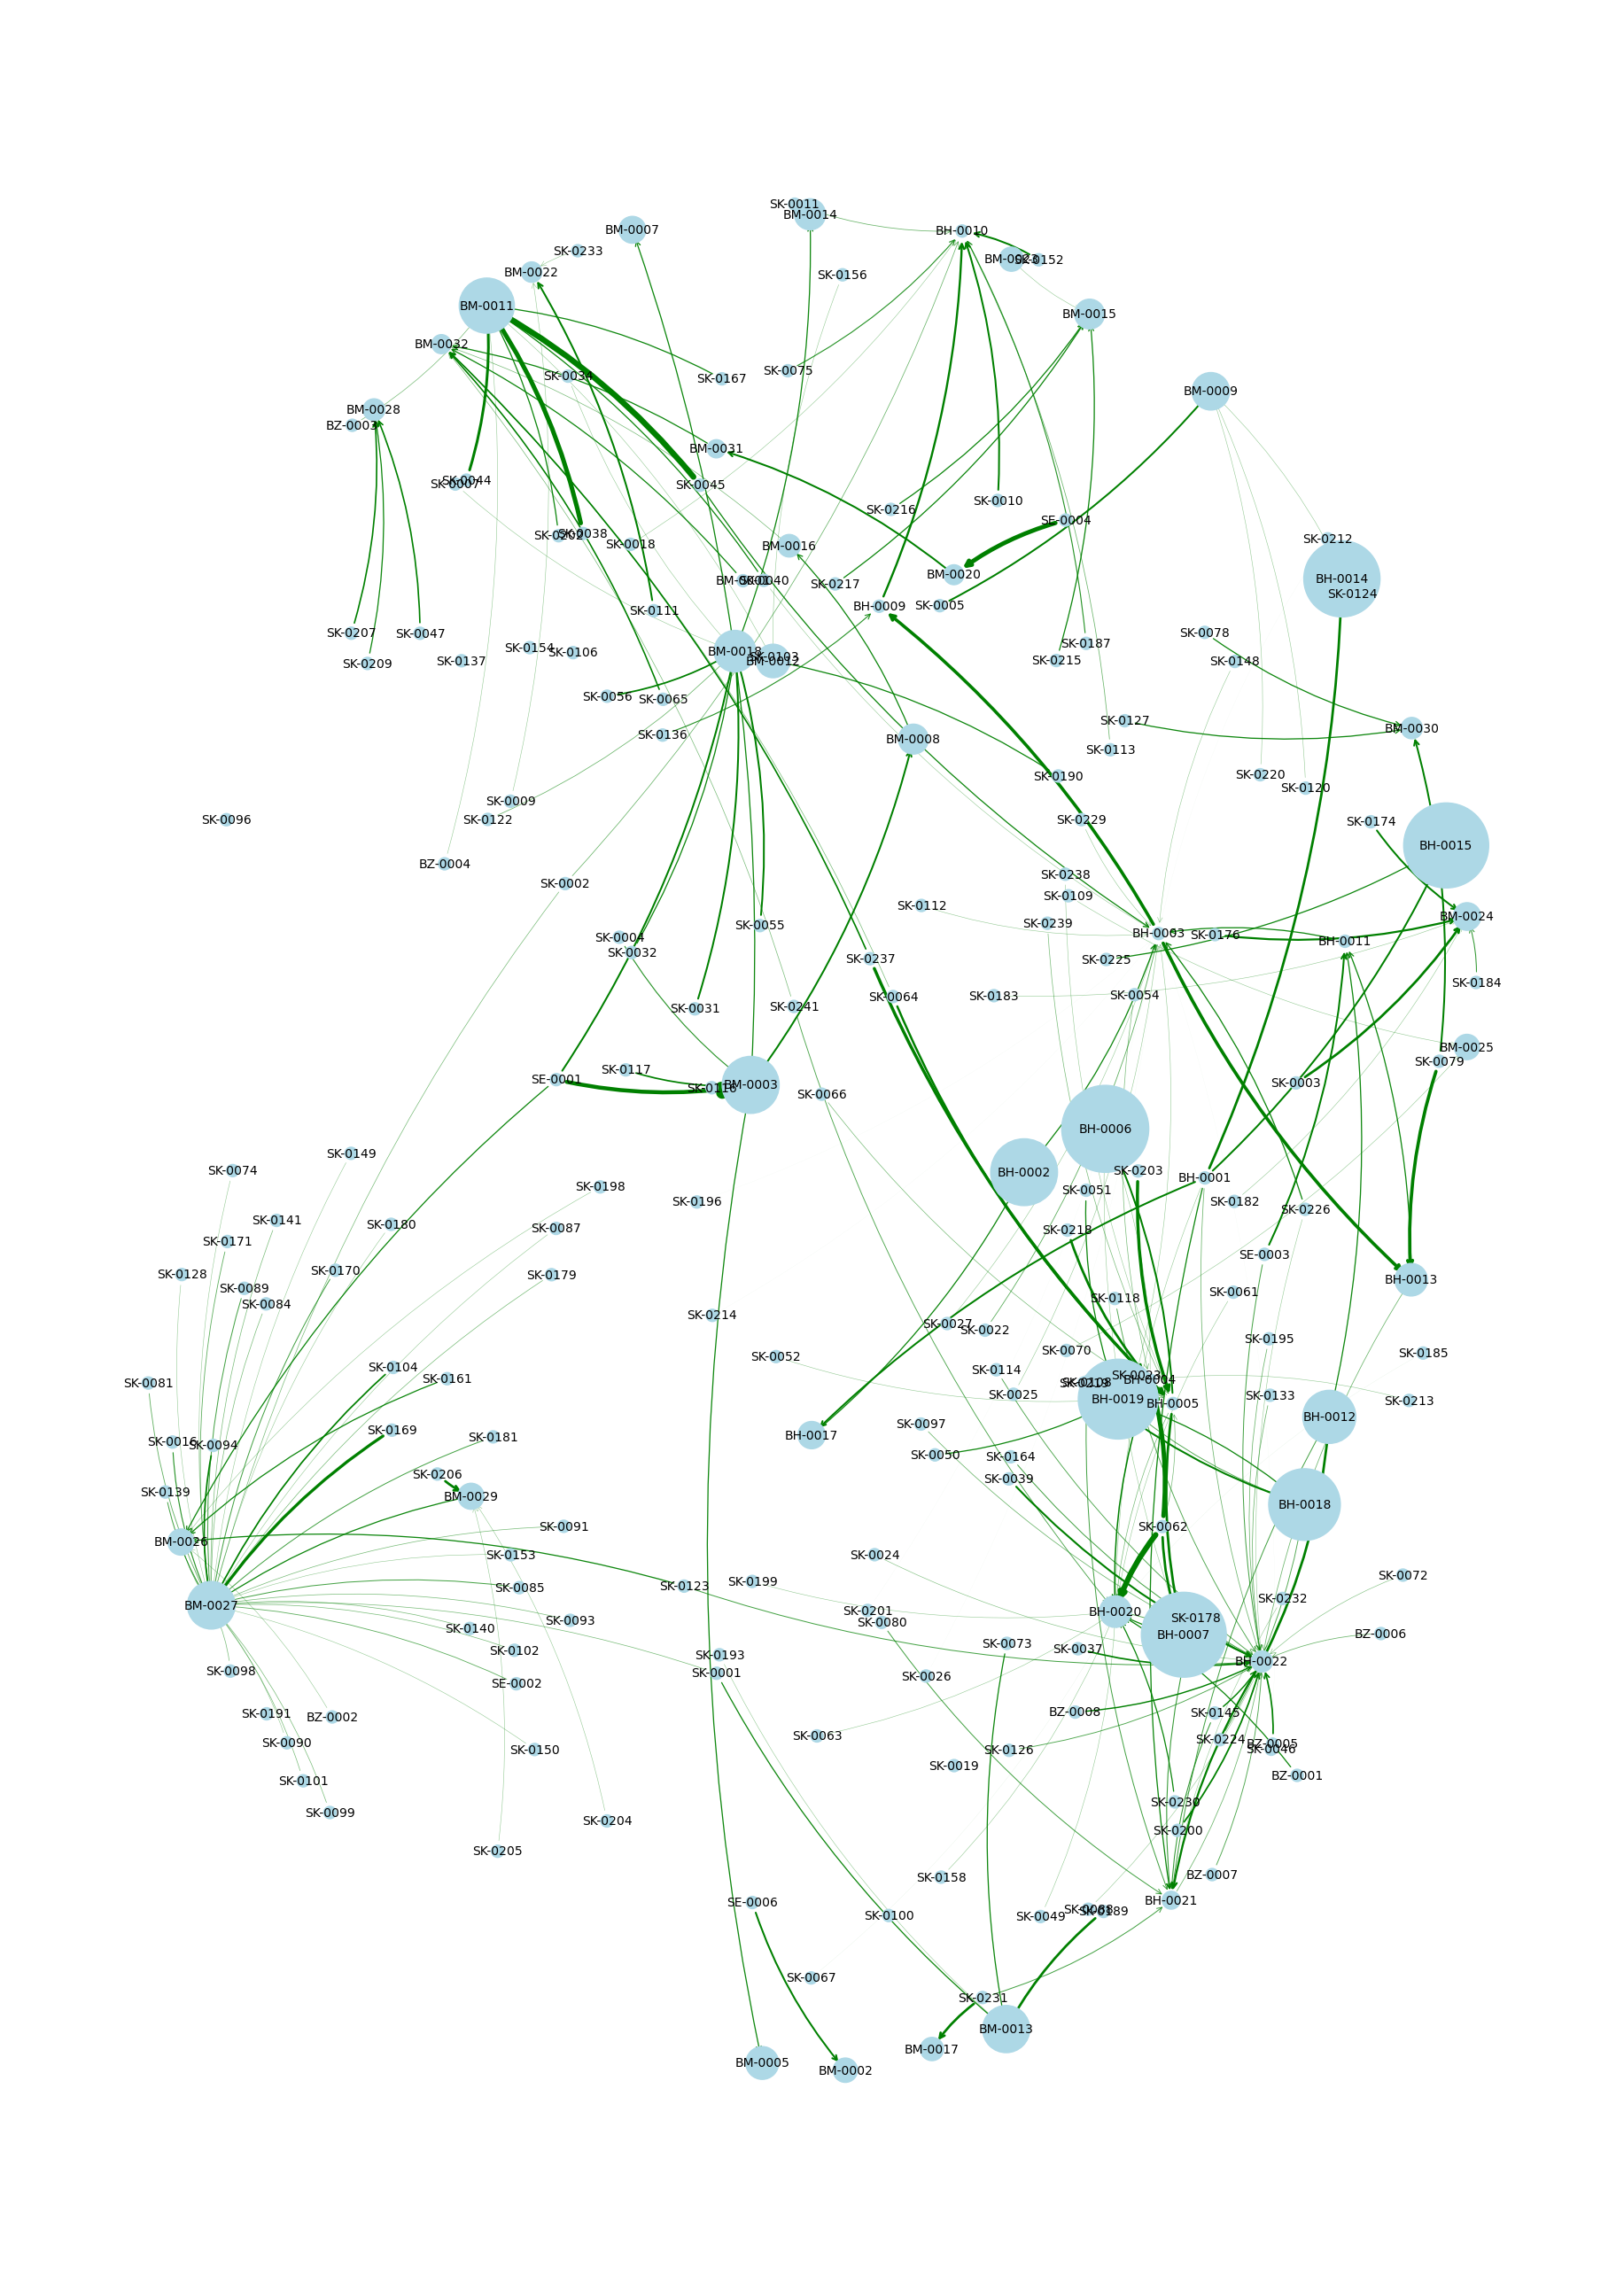

In [77]:

# Create a dictionary to map nodes to labels
node_to_label = dict(zip(node_list['node'], node_list['label']))


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the dataframe using iterrows
for index, row in standard_df.iterrows():
    for item in row['before']:
        before_node = row['before']
        contents_url_node = row['contents_url']
        
        # Get the label for 'before' and 'contents_url' nodes from the mapping
        before_label = node_to_label.get(before_node, '')
        contents_url_label = node_to_label.get(contents_url_node, '')

        G.add_node(before_node, type='before', label=before_label)
        G.add_node(contents_url_node, type='contents_url', label=contents_url_label)
        G.add_edge(before_node, contents_url_node, weight=row['before_count'])
        

        
# Find and remove edges with weight 0
zero_weight_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 0]
G.remove_edges_from(zero_weight_edges)     
# Find isolated nodes
isolated_nodes = list(nx.isolates(G))
# Remove isolated nodes from the graph
G.remove_nodes_from(isolated_nodes)
# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))



plt.figure(figsize=(23.4, 33.1))  # A2 paper size (in inches)
        

# NODE SETTING

# Calculate node sizes based on total views
view_df = pd.read_excel(statistics_path)
view_df['total_views'] = pd.to_numeric(view_df['total_views'], errors='coerce')
view_df = view_df.dropna(subset=['total_views'])
default_node_size = 100  # Default node size (used when there are no views)
max_views = view_df['total_views'].max()  # Calculate the maximum views
node_sizes = {url: 5000 * (views / max_views) if url in view_df['contents_url'].values else default_node_size for url, views in view_df[['contents_url', 'total_views']].values}

pos = nx.fruchterman_reingold_layout(G, k=3, iterations = 600)
# pos = nx.kamada_kawai_layout(G)
# pos = nx.shell_layout(G)

# Draw nodes with labels
node_labels = {node: label for node, label in nx.get_node_attributes(G, 'label').items()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
node_sizes_to_draw = [node_sizes.get(node, default_node_size) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes_to_draw, node_color="lightblue")

# EDGE SETTING

# Calculate edge weight range for scaling
min_weight = min([G[u][v]['weight'] for u, v in G.edges()])
max_weight = max([G[u][v]['weight'] for u, v in G.edges()])
scaling_factor_width = 10

# Create a list of edge widths based on weights
edge_widths = [scaling_factor_width * (G[u][v]['weight'] - min_weight) / (max_weight - min_weight) for u, v in G.edges()]

# Draw edges with specified widths and arrows
edges = nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10, width=edge_widths, edge_color='g', arrows=True, connectionstyle='arc3,rad=0.1')

# Set edge transparency based on edge weights
scaling_factor_alpha = 10
for i, (u, v, d) in enumerate(G.edges(data=True)):
    weight_normalized = (d['weight'] - min_weight) / (max_weight - min_weight)
    weight_alpha = scaling_factor_alpha * weight_normalized
    edges[i].set_alpha(min(1, weight_alpha))  # Limit maximum alpha to 1

# Display the graph
# Save the graph as an image file (e.g., PNG)
plt.savefig('..\PageRelation.png', format='png', dpi = 600)

plt.axis('off')
plt.show()


# Network Graph 해석
## 1. 특정 노드에 대한 정보 얻기 (url, 누적조회수, 연결된 노드들)
## 2. 엣지에 대한 정보 얻기 (연결이 많은 순)


In [22]:
# 원하는 노드의 이름 또는 라벨 설정
desired_node_label = "BM-0027"

In [22]:
# 노드 정보 초기화
node_info = {
    "노드": desired_node_label,
    "누적조회수": None,
    "연결된 노드들": []
}

# 원하는 노드의 정보 검색
for node, data in G.nodes(data=True):
    if data["label"] == desired_node_label or node == desired_node_label:
        node_info["노드"] = node
        break

# 연결된 노드 및 엣지 정보 수집
if node_info["노드"] is not None:
    for predecessor, successor, data in G.in_edges(node_info["노드"], data=True):
        edge_direction = "로 나감"  # 노드에서 연결된 노드로 향하는 방향
        if G.has_edge(successor, predecessor):
            edge_direction = "서 들어옴"  # 연결된 노드에서 노드로 향하는 방향

        node_info["연결된 노드들"].append({
            "연결된 노드": predecessor if edge_direction == "방향: ->" else successor,
            "방향": edge_direction,
            "엣지 웨이트": data["weight"]
        })
        
# 누적조회수 정보 수집
if node_info["노드"] is not None:
    for url, views in view_df[['contents_url', 'total_views']].values:
        if url == node_info["노드"]:
            node_info["누적조회수"] = views

# 결과 출력
print("노드 정보:", desired_node_label)
print("노드:", node_info["노드"])
print("누적조회수:", node_info["누적조회수"])
print()
for connected_node in node_info["연결된 노드들"]:
    print("여기:", connected_node["연결된 노드"])
    print(connected_node["방향"])
    print("이만큼(누적):", connected_node["엣지 웨이트"])    
    print()

노드 정보: BM-0027
노드: https://blog.naver.com/mysecondplace/223298427705
누적조회수: 268.0

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 1.2

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 1.2

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 0.0

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 1.4

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 2.0

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 1.4

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 0.0

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 0.0

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 1.8

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 0.0

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 0.2

여기: https://blog.naver.com/mysecondplace/223298427705
로 나감
이만큼(누적): 1.0

여기: https://blog.naver.com/mysecondplace/

In [23]:
# 연결이 많은 순 = 엣지가 강조된 순
sorted_standard_df = standard_df.sort_values(by='before_count', ascending=False)

sorted_standard_df

,contents_url,before,before_count
155,https://blog.naver.com/mysecondplace/223208249149,세컨 하우스란,19.4
176,https://blog.naver.com/mysecondplace/223250496328,공주시골집매매,9.2
100,https://blog.naver.com/hanpro911/223316230880,노천탕 만들기,8.7
173,https://blog.naver.com/mysecondplace/223250496328,공주 시골집 매매,7.2
24,https://blog.naver.com/hanpro911/222612556607,노천탕 만들기,7.0
...,...,...,...
220,https://blog.naver.com/mysecondplace/223289322164,답경계측량어디다신청,0.0
219,https://blog.naver.com/mysecondplace/223289322164,경계측량신청,0.0
218,https://blog.naver.com/mysecondplace/223289322164,https://blog.naver.com/mysecondplace,0.0
215,https://blog.naver.com/mysecondplace/223283634476,릴호스 수리,0.0


In [24]:
# 빈 리스트 초기화
contents_url_labels = []
before_labels = []

# 'contents_url'과 'before' 열을 순회하면서 'node_list'에서 'label' 값을 찾음
for contents_url, before in zip(sorted_standard_df['contents_url'], sorted_standard_df['before']):
    contents_url_label = node_list[node_list['node'] == contents_url]['label'].values[0]
    before_label = node_list[node_list['node'] == before]['label'].values[0]
    
    contents_url_labels.append(contents_url_label)
    before_labels.append(before_label)

# 결과를 'sorted_standard_df'에 새로운 열로 추가
sorted_standard_df['contents_url_label'] = contents_url_labels
sorted_standard_df['before_label'] = before_labels
sorted_standard_df = sorted_standard_df[['contents_url', 'contents_url_label', 'before_count', 'before', 'before_label']]
sorted_standard_df

,contents_url,contents_url_label,before_count,before,before_label
155,https://blog.naver.com/mysecondplace/223208249149,BM-0003,19.4,세컨 하우스란,SK-0116
176,https://blog.naver.com/mysecondplace/223250496328,BM-0011,9.2,공주시골집매매,SK-0045
100,https://blog.naver.com/hanpro911/223316230880,BH-0020,8.7,노천탕 만들기,SK-0062
173,https://blog.naver.com/mysecondplace/223250496328,BM-0011,7.2,공주 시골집 매매,SK-0038
24,https://blog.naver.com/hanpro911/222612556607,BH-0004,7.0,노천탕 만들기,SK-0062
...,...,...,...,...,...
220,https://blog.naver.com/mysecondplace/223289322164,BM-0023,0.0,답경계측량어디다신청,SK-0071
219,https://blog.naver.com/mysecondplace/223289322164,BM-0023,0.0,경계측량신청,SK-0021
218,https://blog.naver.com/mysecondplace/223289322164,BM-0023,0.0,https://blog.naver.com/mysecondplace,BM-0001
215,https://blog.naver.com/mysecondplace/223283634476,BM-0022,0.0,릴호스 수리,SK-0077
